In [1]:
import os
%pwd

'c:\\Users\\karthikeya\\New_Delhi_Reviews\\notebooks'

In [2]:
os.chdir("..")
%pwd

'c:\\Users\\karthikeya\\New_Delhi_Reviews'

In [3]:
from pathlib import Path
from dataclasses import dataclass
import joblib as jl
import regex as re
import string


import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import KeyedVectors


from src.logger import logger
from src.components.data_ingestion import DataIngestionConfig, DataIngestion
from src.constants import num_columns, text_columns

@dataclass
class DataTransformationConfig:
    preprocessor_obj_file :str = os.path.join("artifacts", "preprocessor.joblib")


@dataclass
class DataColumns:
    Numerical_Columns = num_columns
    Text_Columns = text_columns


In [32]:
df = pd.read_csv(DataIngestionConfig.train_data_path)
df.dropna(inplace=True)
stop_words = set(stopwords.words('english'))

In [33]:
pattern = re.compile(r'[^a-zA-Z]+')

df['review_full']=df['review_full'].apply(lambda x : x.lower())
df['review_full'] = df['review_full'].apply(lambda x: x.split())
# Precompile the regular expression
# df['review_full'] = df['review_full'].apply(lambda x : [re.sub(r'[^a-zA-Z0-9]', ' ', word) for word in x])

df['review_full'] = df['review_full'].apply(lambda x: [pattern.sub('', word) for word in x])
# df['review_full']=df['review_full'].apply(lambda x: [pttrn.sub('', word) for word in x])
df['review_full'] = df['review_full'].apply(lambda x : [word for word in x if not word in stop_words])
df['review_full']

0         [third, fourth, visit, restaurant, past, year,...
1         [well, well, birthday, party, wanted, make, bi...
2         [located, bang, opposite, pvr, plaza, outlet, ...
3         [came, eat, late, lunch, group, , good, time, ...
4         [leather, sofas, colonial, feeling, add, charm...
                                ...                        
103301    [heritage, zaika, nice, place, enjoy, good, fo...
103302    [hard, locate, , good, taste, , good, menu, , ...
103303    [want, finger, licious, south, indian, cuisine...
103304    [great, breakfast, huge, range, careals, fruit...
103305    [, italian, dishes, big, chill, amazing, varie...
Name: review_full, Length: 103304, dtype: object

In [17]:
cleaned_text = re.sub(r'[0-9]+', '', text)


AttributeError: 'int' object has no attribute 'endswith'

In [4]:
class remove_stop_words(TransformerMixin, BaseEstimator):

    def __init__(self):
        
        try:
            logger.info("getting set of stopwords from NLTK from English language")
            self.stop_words = set(stopwords.words('english'))
            pass
        except Exception as e:
            logger.info(f"Error loading set of stopwords from NLTK library: {e}")
            raise e
        

    def fit(self, X):
        return self


    def transform(self, X):
        self.X_ = X.copy()
        try:
            logger.info(f"Transforming all the letters into lowercase")
            self.X_ = self.X_.apply(lambda x: x.str.lower())
            logger.info(f"Transforming all letters into lowercase is successful")

            logger.info(f"Splitting the sentences into words (Tokenization)")
            self.X_ = self.X_.apply(lambda x: x.str.split())
            logger.info(f"Splitting the sentences into words is successful (Tokenization)")

            pattern = re.compile(r'[^a-zA-Z\s]+')  # Allow spaces
            logger.info(f"Removing punctuations from text")
            self.X_ = self.X_.map(lambda x: [pattern.sub('', word) for word in x])
            logger.info(f"Removing punctuations from text successful")


            logger.info(f"Removing the stopwords from the tokenized words")
            self.X_ = self.X_.map(lambda x: [word for word in x if not word in self.stop_words ])
            logger.info(f"Removing the stopwords from the tokenized words is successful")
        except Exception as e:
            logger.info(f"Error in pre-processing the text: {e}")
            raise e
        
        return self.X_


class lemmatization(TransformerMixin, BaseEstimator):

    def __init__ (self):
        try:
            logger.info(f"WordNetLemmatizer from NLTK library is instantiated")
            self.lemmatizer = WordNetLemmatizer()
            pass
        except Exception as e:
            logger.info(f"Error initiating the lemmatizer from NLTK library: {e}")
            raise e
        
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        self.X_ = X.copy()
        try:
            logger.info(f"Initiating the lemmatization of the remaining words after stopword removal")
            self.X_ = self.X_.map(lambda x: [self.lemmatizer.lemmatize(word) for word in x])
            logger.info(f"Lemmatization successful")
        except Exception as e:
            logger.info(f"Error in lemmatization: {e}")
            raise e
        return self.X_
    
class make_embeddings(TransformerMixin, BaseEstimator):

    def __init__(self):
        try:
            logger.info("Loading Gensim Word2Vec model for embedding generation")
            self.word2vec = KeyedVectors.load_word2vec_format("ft_reviews_vectors.bin", binary=True)  # Update path as needed
            pass
        except Exception as e:
            logger.info(f"Error loading Gensim Word2Vec model: {e}")
            raise e

    def fit(self, X):

        return self

    def transform(self, X):
        self.X_ = X.copy()
        try:
            logger.info("Generating embeddings for the text data")
            
            # Compute embeddings using Gensim's get_mean_vector method
            embeddings = self.X_.map(lambda words: self.word2vec.get_mean_vector(words, ignore_missing=True))

            logger.info("Successfully generated embeddings")
            return embeddings
        except Exception as e:
            logger.error(f"Error during transformation: {e}")
            raise e

In [11]:
class DataTransformation(TransformerMixin, BaseEstimator):

    def __init__ (self):
        try:
            logger.info(f"Initiating the DataTransformation")
            self.data_transformation_config = DataTransformationConfig()
            self.data_columns = DataColumns()
            pass
        
        except Exception as e:
            logger.info(f"Error initiating the DataTransformation : {e}")
            raise e
        

    def get_transformer_object(self):
        try:
            num_pipeline = Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
                ]
            )

            text_pipeline = Pipeline([
                ("clean and preprocess", remove_stop_words()),
                ("lemmatize the words", lemmatization()),
                ("Create Embeddings", make_embeddings())
            ])
            
            logger.info("Numerical and text pipelines created")
            
            preprocessor = ColumnTransformer([
                ("Numerical_Pipeline", num_pipeline, self.data_columns.Numerical_Columns),
                ("Text_Pipeline", text_pipeline, self.data_columns.Text_Columns)
            ])

            return preprocessor  
        except Exception as e:
            raise e
    
    def initiate_data_transformation(self, train_data_path, test_data_path):

        try:
            logger.info(f"Initiatig data transformation pipeline")
            train_data = pd.read_csv(train_data_path)
            test_data = pd.read_csv(test_data_path)
            train_data.dropna(inplace=True, axis=0)
            test_data.dropna(inplace=True, axis=0)
            


            self.preprocessing_obj = self.get_transformer_object()
            input_feature_arr = self.preprocessing_obj.fit_transform(train_data)
            input_test_arr = self.preprocessing_obj.transform(test_data)

            jl.dump(preprocessing_obj, self.data_transformation_config.preprocessor_obj_file)
            logger.info(f"Saved fitted preprocessor to {self.data_transformation_config.preprocessor_obj_file}")

            logger.info(f"Returning the input train feature as an array and test feature as array respectively")
            return input_feature_arr, input_test_arr
        except Exception as e:
            logger.info(f"Error in initiating the data transformation pipeline {e}")
            raise e


In [44]:
from gensim.models import FastText

# Training the FastText model
# Define parameters like vector size, window size, and minimum word count
model = FastText(
    sentences=df['review_full'].to_list(),    # Input data
    vector_size=25,      # Size of word vectors
    window=5,             # Context window size
    min_count=1,          # Minimum word frequency to include
    sg=1,                 # Skip-gram model (1) or CBOW (0)
    epochs=10,             # Number of iterations (training epochs)
    workers=8                               # Number of CPU cores to use (set to your available cores)

)

# Discard unnecessary data to reduce size
model.wv.init_sims(replace=True)

# Save only the word vectors in binary format
model.wv.save_word2vec_format("ft_reviews_vectors.bin", binary=True)



[2024-12-14 16:24:26,944, word2vec, INFO, collecting all words and their counts ]
[2024-12-14 16:24:26,946, word2vec, INFO, PROGRESS: at sentence #0, processed 0 words, keeping 0 word types ]
[2024-12-14 16:24:27,061, word2vec, INFO, PROGRESS: at sentence #10000, processed 408439 words, keeping 26554 word types ]
[2024-12-14 16:24:27,163, word2vec, INFO, PROGRESS: at sentence #20000, processed 809383 words, keeping 39092 word types ]
[2024-12-14 16:24:27,264, word2vec, INFO, PROGRESS: at sentence #30000, processed 1218278 words, keeping 49917 word types ]
[2024-12-14 16:24:27,377, word2vec, INFO, PROGRESS: at sentence #40000, processed 1623949 words, keeping 59450 word types ]
[2024-12-14 16:24:27,462, word2vec, INFO, PROGRESS: at sentence #50000, processed 2028560 words, keeping 67824 word types ]
[2024-12-14 16:24:27,564, word2vec, INFO, PROGRESS: at sentence #60000, processed 2431931 words, keeping 75714 word types ]
[2024-12-14 16:24:27,655, word2vec, INFO, PROGRESS: at sentence #7

C:\Users\karthikeya\AppData\Local\Temp\ipykernel_15100\78524876.py:17: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.wv.init_sims(replace=True)


In [45]:
model = KeyedVectors.load_word2vec_format("ft_reviews_vectors.bin", binary=True)

[2024-12-14 16:27:42,577, keyedvectors, INFO, loading projection weights from ft_reviews_vectors.bin ]
[2024-12-14 16:27:43,820, utils, INFO, KeyedVectors lifecycle event {'msg': 'loaded (106574, 25) matrix of type float32 from ft_reviews_vectors.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2024-12-14T16:27:43.820247', 'gensim': '4.3.3', 'python': '3.9.21 | packaged by conda-forge | (main, Dec  5 2024, 13:41:22) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'} ]


In [46]:
model.most_similar("cp", topn=15)

[('onnaught', 0.9587024450302124),
 ('connaughtplace', 0.9568647146224976),
 ('connnaught', 0.9519844055175781),
 ('cannaught', 0.9518898129463196),
 ('cpc', 0.9517862200737),
 ('connaught', 0.9508863091468811),
 ('barconnaught', 0.9465137720108032),
 ('citycannaught', 0.9443777799606323),
 ('connaughat', 0.9442583322525024),
 ('connaght', 0.9405683875083923),
 ('connaugt', 0.9399679899215698),
 ('connaughts', 0.9386332631111145),
 ('conaught', 0.9384315013885498),
 ('circlei', 0.9336044788360596),
 ('caunnaught', 0.9283806681632996)]

In [3]:
import pandas as pd
import numpy as np

In [9]:
from src.components.data_ingestion import DataIngestion
from src.components.data_transformation import DataTransformation

In [10]:
data_ingest = DataIngestion()
tr_D, ts_D = data_ingest.initate_data_ingestion()
data_trans = DataTransformation()
train_data, test_data = data_trans.initiate_data_transformation(tr_D, ts_D)

[2024-12-20 22:40:32,446, data_ingestion, INFO, Initiating data ingestion ]
[2024-12-20 22:40:32,448, data_ingestion, INFO, Establising Connection With SQL Database ]
[2024-12-20 22:40:32,454, data_ingestion, INFO, Successfully connected to the SQLite database. ]
[2024-12-20 22:40:32,455, data_ingestion, INFO, Reading New_Delhi_Reviews table  ]
[2024-12-20 22:40:32,876, data_ingestion, INFO, Successfully read the New_Delhi_Reviews as pandas dataframe ]
[2024-12-20 22:40:36,574, data_ingestion, INFO, succesfully ingested the raw data as a csv file into artifacts\raw_data.csv ]
[2024-12-20 22:40:36,577, data_ingestion, INFO, Initiating train test split ]
[2024-12-20 22:40:38,207, data_ingestion, INFO, train and test data split successful and stored respectively as csv files at artifacts\train_data.csv, artifacts\test_data.csv ]
[2024-12-20 22:40:38,237, data_transformation, INFO, Initiating the DataTransformation ]
[2024-12-20 22:40:38,238, data_transformation, INFO, Initiatig data trans

In [11]:
np.random.seed(42)

In [12]:
import umap

In [13]:
reducer = umap.UMAP(n_neighbors = 100, min_dist = 0.5, metric='cosine', random_state=42)
embedding = reducer.fit_transform(train_data)
embedding.shape

c:\Users\karthikeya\New_Delhi_Reviews\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\karthikeya\New_Delhi_Reviews\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(103304, 2)

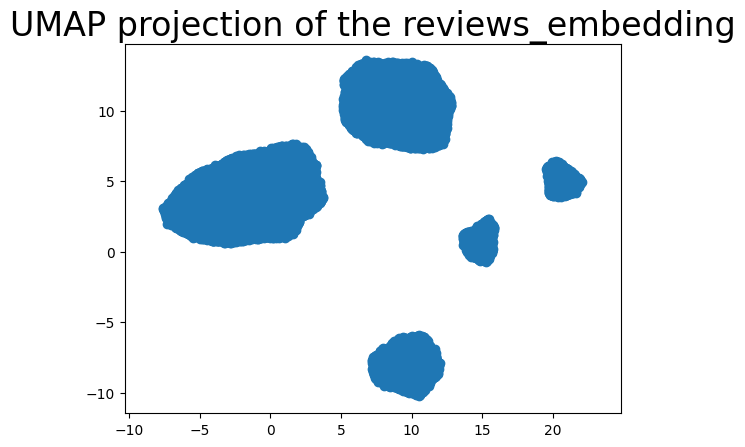

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
   )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the reviews_embedding', fontsize=24);

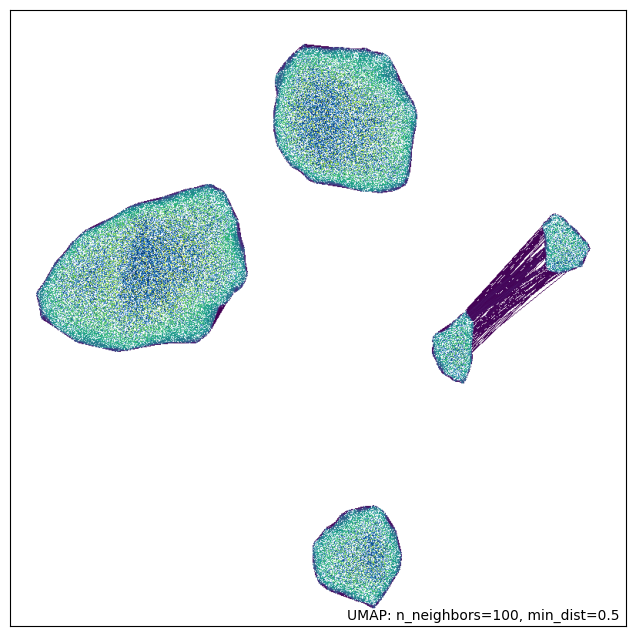

In [16]:
from umap import plot
plot.connectivity(reducer, show_points=True, edge_cmap= 'viridis')
plt.show()